In [0]:
GDRIVE_STORAGE = True

if GDRIVE_STORAGE:

  from google.colab import drive
  drive.mount('/content/gdrive')
  path_to_archive = "gdrive/My\ Drive/Colab\ datasets/the-simpsons-characters-dataset.zip"


!ls gdrive/My\ Drive/Colab\ datasets || true

!unzip gdrive/My\ Drive/Colab\ datasets/the-simpsons-characters-dataset.zip  || true
!rm -r simpsons_dataset/simpsons_dataset || true
!ls kaggle_simpson_testset/kaggle_simpson_testset || true
!rm kaggle_simpson_testset/kaggle_simpson_testset/mayor_quimby_* || true
!rm kaggle_simpson_testset/kaggle_simpson_testset/lenny_leonard_* || true

#### Вспомогательные либы

In [0]:
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sklearn
from collections import Counter
import glob
import pickle
import keras
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### ЛР 1. Разработка полностью связанных нейронных сетей

### Постановка задачи

Мы выбрали задачу предсказывания персонажей из мультсериала **Симпсоны**. Набор данных содержит **18 классов / персонажей** (данные по Kaggle содержат 20 классов, но в настоящее время мы использовали только 18 персонажений для обучения). Изображения имеют различный размер и в основном извлечены из эпизодов (сезон 4-24).

In [0]:
map_characters = {
    0: 'abraham_grampa_simpson',
    1: 'apu_nahasapeemapetilon', 
    2: 'bart_simpson', 
    3: 'charles_montgomery_burns', 
    4: 'chief_wiggum', 
    5: 'comic_book_guy', 
    6: 'edna_krabappel', 
    7: 'homer_simpson', 
    8: 'kent_brockman', 
    9: 'krusty_the_clown', 
    10: 'lisa_simpson', 
    11: 'marge_simpson', 
    12: 'milhouse_van_houten', 
    13: 'moe_szyslak', 
    14: 'ned_flanders', 
    15: 'nelson_muntz', 
    16: 'principal_skinner', 
    17: 'sideshow_bob'
}

Картинки имеют формат BGR и разный размер. Поэтому приведет все картинки к фиксированному размеру и к формату RGB. Сразу картинки не будем загружать в память, во избежания переполнения памяти в оперативке. Загружать будем во время батча для тренировки или предсказания

In [0]:
def show_image_from_path(ax, x, y):
    y = map_characters[y]
    img = cv2.imread(x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    ax.imshow(img)
    ax.text(2, 58, '{}'.format(y), fontsize=12, bbox={'facecolor': 'white', 'pad': 2})

def show_image(ax, image, label):
    ax.imshow(image)
    ax.text(2, 58, '{}'.format(map_characters[label]), fontsize=12, bbox={'facecolor': 'white', 'pad': 2}) 
    
def show_image_with_dict(ax, image, l):
    ax.imshow(image)
    labels = ['{}: {:.2f}'.format(label, value) for label, value in l]
    text = '\n'.join(labels)
    ax.text(2, 58, text, fontsize=9, bbox={'facecolor': 'white', 'pad': 2})
    
def print_example(X,Y):
    f, axes = plt.subplots(4, 6, sharey=True, figsize=(18, 12))
    for i, ax in enumerate(axes.flat):
        show_image_from_path(ax, X[i], Y[i])

In [0]:
def collect_train_paths(images_dir = 'simpsons_dataset/'):
    np.random.seed(42)
    x_path_train = []
    y_train = []
    for key, value in map_characters.items():
        person_images_path = os.listdir(os.path.join(images_dir, value))
        person_images_path.sort()
        x_path_train.extend(list(map(lambda x: os.path.join(images_dir, value, x), person_images_path)))
        y_train.extend([key]*len(person_images_path))

    x_path_train = np.array(x_path_train)
    y_train = np.array(y_train)

    indices = np.arange(x_path_train.shape[0])
    np.random.shuffle(indices)
    x_path_train = x_path_train.take(indices, axis=0)
    y_train = y_train.take(indices, axis=0)
        
    return x_path_train, y_train

In [0]:
def collect_test_paths(images_dir = 'kaggle_simpson_testset/kaggle_simpson_testset'):
    np.random.seed(42)
    x_test_path = []
    y_test = []
    for image_name in os.listdir(images_dir):
        character_name = "_".join(image_name.split('_')[:-1])
        label = [label for label, character in map_characters.items() if character == character_name][0]
        x_test_path.append(os.path.join(images_dir, image_name))
        y_test.append(label)
    
    x_test_path = np.array(x_test_path)
    y_test = np.array(y_test)
    indices = np.arange(x_test_path.shape[0])
    np.random.shuffle(indices)
    x_test_path = x_test_path.take(indices, axis=0)
    y_test = y_test.take(indices, axis=0)
    
    return np.array(x_test_path), np.array(y_test)

Получаем пошафленную тренировочную выборку в виде путей. (Сразу загрузгу не делаем картинок)

In [0]:
if GDRIVE_STORAGE:
    x_train_paths, y_train = collect_train_paths()
else:
    x_train_paths, y_train = collect_train_paths('/export/users/kpetrov/simpsons/simpsons_dataset')

### Тренировочные и тестовые наборы данных.

Тренировочная выборка включает в себя около **1000 изображений на каждого персонажа**. Персонаж не обязательно центрируется на каждом изображении и иногда может быть с другими персонажами (но это должно быть самой важной частью на картинке).

Отобразим несколько картинок тренировочной выборки

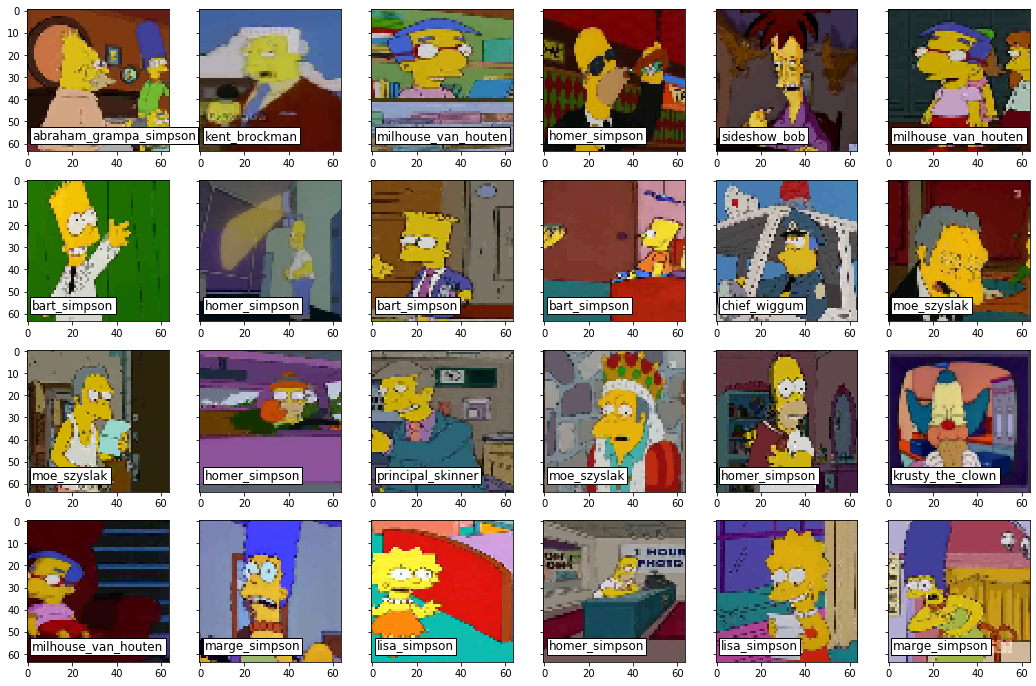

In [0]:
f, axes = plt.subplots(4, 6, sharey=True, figsize=(18, 12))
for i, ax in enumerate(axes.flat):
    show_image_from_path(ax, x_train_paths[i], y_train[i]) 

Функции для выдерания батч путей картинок и неспосредственно загрузка батч картинок

In [0]:
def load_from_paths(x_path_batch, img_size=64):
    batches = np.empty((len(x_path_batch), img_size, img_size, 3))

    for i, x_path_i in enumerate(x_path_batch):
        img = cv2.imread(x_path_i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype('float32') / 255.
        assert img.min() >= 0.0 and img.max() <= 1.0
        batches[i] = img
    return batches

def load_from_paths_batch(x_path, y, batch_size, img_size=64):
    SEED = 42
    np.random.seed(SEED)
    
    n_batch = len(x_path) // batch_size
    while (True):
        indices = np.arange(x_path.shape[0])
        np.random.shuffle(indices)
        x_path_take = x_path.take(indices, axis=0)
        y_take = y.take(indices, axis=0)

        for i in range(0, len(x_path), batch_size):
            x_path_batch = x_path_take[i : i + batch_size]
            y_batch = y_take[i : i + batch_size]
            batches = load_from_paths(x_path_batch, img_size)
            yield (batches, y_batch)

Проверим, что они корректно работают:

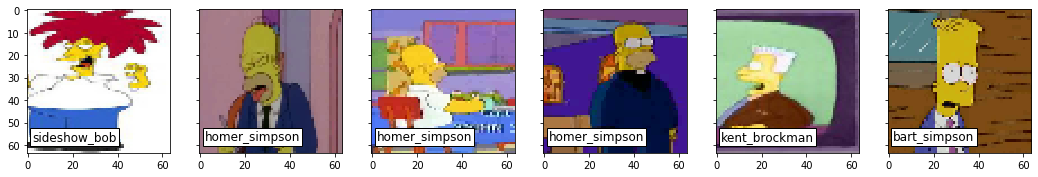

In [0]:
n_image = 6
gen = load_from_paths_batch(x_train_paths, y_train, n_image)
(im, index) = gen.__next__()
f, axes = plt.subplots(1, n_image, sharey=True, figsize=(3*n_image, 3))
for i, ax in enumerate(axes):
    show_image(ax, im[i], index[i])

Валидироваться будем на валидационном датасете, который выделим из тренировочного.

In [0]:
def split_data_set(X, Y):
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.01, random_state=777)
    return x_train, x_val, y_train, y_val

In [0]:
x_train_paths, x_val_paths, y_train, y_val = split_data_set(x_train_paths, y_train)
"train size {} validation size {}".format(x_train_paths.shape, x_val_paths.shape)

'train size (18802,) validation size (190,)'

Тестовая выборка состоит из 50 картнинок на каждого персонажа. Но использовать тестовые данные будем **только на финальной модели** в каждой лабораторной.

Методы для тренировки и тестирования наших моделей:

In [0]:
def train_model(model, X_train, Y_train, X_val, Y_val, epoch, batch_size, img_size=64, verbose=1):
    SEED = 65
    import random 
    random.seed(SEED)
    np.random.seed(SEED)
    
    n_batch = len(X_train) // batch_size
    X_val = load_from_paths(X_val, img_size)
    generator = load_from_paths_batch(X_train, Y_train, batch_size, img_size)
    model.fit_generator(generator, steps_per_epoch=n_batch, epochs=epoch, verbose=verbose, validation_data=[X_val, Y_val])
    return model
    
def test_model(model, x_test, img_size=64):
    x_test = load_from_paths(x_test)
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, 1)
    return y_pred

In [0]:
def visualize_results(x_test, y_pred):
    y_pred = list(map(lambda y_pred_i: sorted(zip(map_characters.values(), y_pred_i), key=lambda kv: kv[1], reverse=True)[:3], y_pred))

    indices = np.arange(x_test.shape[0])
    np.random.shuffle(indices)

    f, axes = plt.subplots(4, 6, sharey=True, figsize=(18, 12))
    for i, ax in enumerate(axes.flat):
        show_image_with_dict(ax, x_test[i], y_pred[i]) 

Для исскуственного увеличения исходной выборки можем попробовать использовать аутментацию - каждое изображение может быть видоизменено для создания новых экземпляров. Под видоизменением могут подразумеваться сдвиги, повороты, зеркальные отражения и прочее. В библиотеке Keras для аугментации существует класс ImageDataGenerator. В частности, у генератора с аугментацией есть возможность загружать сэмплы из конкретной директории, чем мы и воспользуемся:

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
def create_augmentation_generator(img_size=64, batch_size=256):
    dataset_dir = 'simpsons_dataset/'

    datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False
    )
    
    generator = datagen.flow_from_directory(
        directory=dataset_dir,
        target_size=(img_size,img_size),
        color_mode='rgb',
        class_mode='sparse',
        batch_size=batch_size,
        classes=map_characters.values()
    )

    return generator

### ЛР2. Разработка сверточных нейронных сетей

Напишем обобщенную функцию построения модели, где будем смотреть следующие параметры: 
    
1. Параметр регулиризации
2. Количество сверточных слоев
3. Количество сверток
4. Нормализацию после каждого конвалюционного слоя

В качестве **головы** мы будем использовать налучший результат из предыдущей работы.

$$n \times 64 \times 64 \times 3 \rightarrow n \times 64 \times 64 \times conv_{n} \rightarrow RELU \rightarrow n \times 32 \times 32 \times conv_{n} \rightarrow n \times 512 \rightarrow RELU \rightarrow n \times 18 \rightarrow SOFTMAX$$


In [0]:
def build_own_conv_model(img_size=64, l2_reg=0.0, n_layers=1, n_conv=16, batch_norm=False):
    from keras.models import Sequential
    from keras.layers.core import Dense, Dropout, Activation, Flatten
    from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
    from keras.layers.normalization import BatchNormalization
    from keras.regularizers import l2
    
    n_classes = len(map_characters)

    model = Sequential()
    model.add(Conv2D(n_conv, (5, 5), input_shape=(img_size, img_size, 3), padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    for i in range(n_layers - 1):
        model.add(Conv2D(n_conv, (3, 3), padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        if batch_norm: model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))

    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
    
    model.compile(
        optimizer="adam", 
        loss=keras.losses.sparse_categorical_crossentropy, 
        metrics=[keras.metrics.sparse_categorical_accuracy]
    )
    
    return model

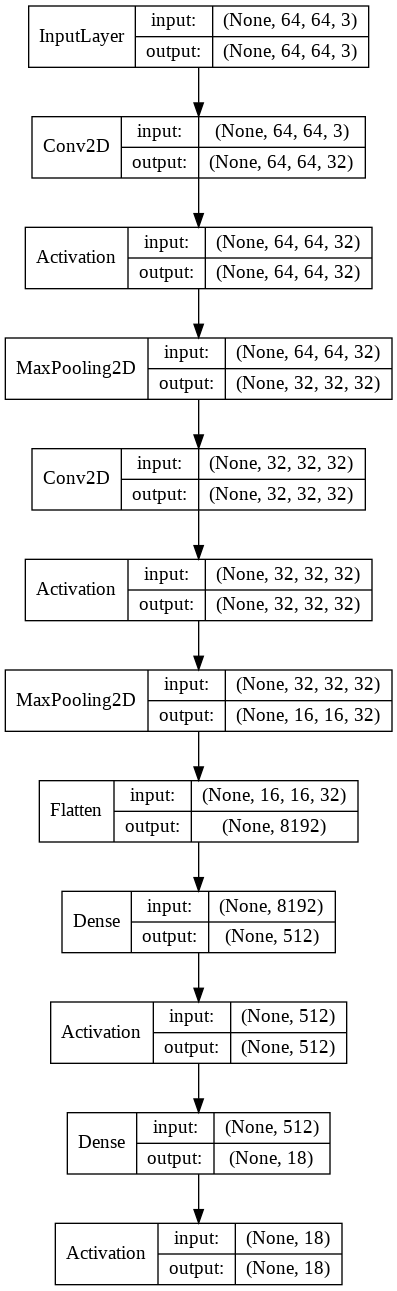

In [0]:
model = build_own_conv_model(n_layers=2, n_conv=32)
plot_model(model, show_shapes=True, show_layer_names=False)

Пример архитектуры одной модели

In [0]:
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 64, 64, 64)        4864      
_________________________________________________________________
activation_115 (Activation)  (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_116 (Activation)  (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 16, 16, 64)      

In [0]:
model = build_own_conv_model()
train_model_augmentation(model, x_train_paths, y_train, x_val_paths, y_val,
                            epoch=10, batch_size=512, verbose=1)
pass

Epoch 1/10
36/36 [==============================] - 48s 1s/step - loss: 3.5000 - sparse_categorical_accuracy: 0.1067 - val_loss: 2.7804 - val_sparse_categorical_accuracy: 0.1158
Epoch 2/10
36/36 [==============================] - 47s 1s/step - loss: 2.5753 - sparse_categorical_accuracy: 0.1992 - val_loss: 2.3764 - val_sparse_categorical_accuracy: 0.2684
Epoch 3/10
36/36 [==============================] - 47s 1s/step - loss: 2.1626 - sparse_categorical_accuracy: 0.3502 - val_loss: 2.0098 - val_sparse_categorical_accuracy: 0.3789
Epoch 4/10
36/36 [==============================] - 47s 1s/step - loss: 1.8590 - sparse_categorical_accuracy: 0.4619 - val_loss: 1.7557 - val_sparse_categorical_accuracy: 0.4684
Epoch 5/10
36/36 [==============================] - 47s 1s/step - loss: 1.6341 - sparse_categorical_accuracy: 0.5331 - val_loss: 1.5597 - val_sparse_categorical_accuracy: 0.5368
Epoch 6/10
36/36 [==============================] - 47s 1s/step - loss: 1.4354 - sparse_categorical_accuracy: 

При первом приближении сразу улучшили с **0.41** до **0.66**. Попробуем увеличить количество уровней сверток

In [0]:
model = build_own_conv_model(n_layers=2, n_conv=32)
train_model_augmentation(model, x_train_paths, y_train, x_val_paths, y_val, 
                            epoch=10, batch_size=512, verbose=1)
pass

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
36/36 [==============================] - 58s 2s/step - loss: 4.4084 - sparse_categorical_accuracy: 0.2101 - val_loss: 2.1789 - val_sparse_categorical_accuracy: 0.3053
Epoch 2/10
36/36 [==============================] - 52s 1s/step - loss: 1.9238 - sparse_categorical_accuracy: 0.4374 - val_loss: 1.7561 - val_sparse_categorical_accuracy: 0.4737
Epoch 3/10
36/36 [==============================] - 52s 1s/step - loss: 1.6606 - sparse_categorical_accuracy: 0.5200 - val_loss: 1.6814 - val_sparse_categorical_accuracy: 0.5053
Epoch 4/10
36/36 [==============================] - 52s 1s/step - loss: 1.5489 - sparse_categorical_accuracy: 0.5546 - val_loss: 1.5754 - val_sparse_categorical_accuracy: 0.5158
Epoch 5/10
36/36 [==============================] - 52s 1s/step - loss: 1.4040 - sparse_categorical_accuracy: 0.5984 - val_loss: 1.4959 - val_sparse_categorical_accuracy: 0.5368
Epoch 6/10
36/36

Лучше не стало. Попробуем подобрать оптимальные гиперпараметры.

In [0]:
img_size = 64
epoch = 10
batch_size = 512
n_conv=32

for n_conv in [32, 64]:
    for l2_reg in [0.5]:
        for n_layers in [2, 3]:
            print("l2_reg =", l2_reg, "| n_layers =", n_layers, "| n_conv = ", n_conv)
            model = build_own_conv_model(img_size=img_size, l2_reg=l2_reg, 
                                         n_layers=n_layers, n_conv=n_conv)

            start = time.time()
            train_model_augmentation(model, x_train_paths, y_train, x_val_paths, y_val,
                        epoch=epoch, batch_size=batch_size, img_size=img_size, verbose=0)
            end = time.time()
            print("Time(sec): \t ", end - start)

            pred_train  = test_model(model, x_train_paths, img_size=img_size)
            print("Training: \t" , (pred_train == y_train).mean())

            pred_val  = test_model(model, x_val_paths, img_size=img_size)
            print("Validation: \t" , (pred_val == y_val).mean())

            print("########################################")

l2_reg = 0.5 | n_layers = 2 | n_conv =  32
Found 18992 images belonging to 18 classes.
Time(sec): 	  1332.3116495609283
Training: 	 0.5581852994362302
Validation: 	 0.5526315789473685
########################################
l2_reg = 0.5 | n_layers = 3 | n_conv =  32
Found 18992 images belonging to 18 classes.
Time(sec): 	  1310.5090472698212
Training: 	 0.43516647165195194
Validation: 	 0.4631578947368421
########################################
l2_reg = 0.5 | n_layers = 2 | n_conv =  64
Found 18992 images belonging to 18 classes.
Time(sec): 	  1213.5710439682007
Training: 	 0.5505797255611106
Validation: 	 0.5736842105263158
########################################
l2_reg = 0.5 | n_layers = 3 | n_conv =  64
Found 18992 images belonging to 18 classes.
Time(sec): 	  1030.2003185749054
Training: 	 0.45543027337517283
Validation: 	 0.45789473684210524
########################################


In [0]:
img_size = 64
epoch = 10
batch_size = 512
n_conv=32

for n_conv in [32, 64]:
    for l2_reg in [0]:
        for n_layers in [2, 3]:
            print("l2_reg =", l2_reg, "| n_layers =", n_layers, "| n_conv = ", n_conv)
            model = build_own_conv_model(img_size=img_size, l2_reg=l2_reg, 
                                         n_layers=n_layers, n_conv=n_conv)

            start = time.time()
            train_model_augmentation(model, x_train_paths, y_train, x_val_paths, y_val,
                        epoch=epoch, batch_size=batch_size, img_size=img_size, verbose=0)
            end = time.time()
            print("Time(sec): \t ", end - start)

            pred_train  = test_model(model, x_train_paths, img_size=img_size)
            print("Training: \t" , (pred_train == y_train).mean())

            pred_val  = test_model(model, x_val_paths, img_size=img_size)
            print("Validation: \t" , (pred_val == y_val).mean())

            print("########################################")

l2_reg = 0 | n_layers = 2 | n_conv =  32
Found 18992 images belonging to 18 classes.
Time(sec): 	  971.7156715393066
Training: 	 0.709658546963089
Validation: 	 0.7263157894736842
########################################
l2_reg = 0 | n_layers = 3 | n_conv =  32
Found 18992 images belonging to 18 classes.
Time(sec): 	  878.9515273571014
Training: 	 0.7869375598340602
Validation: 	 0.8
########################################
l2_reg = 0 | n_layers = 2 | n_conv =  64
Found 18992 images belonging to 18 classes.
Time(sec): 	  914.0672070980072
Training: 	 0.7286990745665355
Validation: 	 0.7421052631578947
########################################
l2_reg = 0 | n_layers = 3 | n_conv =  64
Found 18992 images belonging to 18 classes.
Time(sec): 	  1010.5671610832214
Training: 	 0.8378364003829379
Validation: 	 0.8263157894736842
########################################


Регулиризация в наших моделях не принесла большой пользы. Лучше всего получилось в трехслойном конвалюционном слое - **0.8** на валидационной выборке! 

| Model                                      | time (sec) | training accuracy | validate accuracy |
|--------------------------------------------|------------|-------------------|-------------------|
|l2_reg = 0.5 ; n_layers = 2 ; n_conv =  32  | 1332.3     | 0.55              | 0.55              |
|l2_reg = 0.5 ; n_layers = 3 ; n_conv =  32  | 1310.5     | 0.43              | 0.46              |
|l2_reg = 0.5 ; n_layers = 2 ; n_conv =  64  | 1213.5     | 0.55              | 0.57              |
|l2_reg = 0.5 ; n_layers = 3 ; n_conv =  64  | 1030.4     | 0.45              | 0.46              |
|l2_reg = 0   ; n_layers = 2 ; n_conv =  32  | 971.7      | 0.70              | 0.72              |
|l2_reg = 0   ; n_layers = 3 ; n_conv =  32  | 878.9      | 0.78              | 0.80              | 
|l2_reg = 0   ; n_layers = 2 ; n_conv =  64  | 913.5      | 0.72              | 0.74              |

Выберем её как финальную модель для второй лабораторной работы и увеличим количество эпох

In [0]:
%%time
model = build_own_conv_model(n_layers=3, n_conv=32, l2_reg=0.0,  batch_norm=False)
train_model_augmentation(model, x_train_paths, y_train, x_val_paths, y_val, 
                            epoch=30, batch_size=512, verbose=0)
pass

Found 18992 images belonging to 18 classes.
Epoch 1/30
36/36 [==============================] - 98s 3s/step - loss: 2.8121 - sparse_categorical_accuracy: 0.1319 - val_loss: 2.4420 - val_sparse_categorical_accuracy: 0.3053
Epoch 2/30
36/36 [==============================] - 96s 3s/step - loss: 2.2617 - sparse_categorical_accuracy: 0.3050 - val_loss: 1.9294 - val_sparse_categorical_accuracy: 0.3947
Epoch 3/30
36/36 [==============================] - 98s 3s/step - loss: 1.9192 - sparse_categorical_accuracy: 0.4289 - val_loss: 1.5515 - val_sparse_categorical_accuracy: 0.5158
Epoch 4/30
36/36 [==============================] - 103s 3s/step - loss: 1.6920 - sparse_categorical_accuracy: 0.4991 - val_loss: 1.4287 - val_sparse_categorical_accuracy: 0.5632
Epoch 5/30
36/36 [==============================] - 108s 3s/step - loss: 1.5696 - sparse_categorical_accuracy: 0.5317 - val_loss: 1.2670 - val_sparse_categorical_accuracy: 0.6211
Epoch 6/30
36/36 [==============================] - 101s 3s/step

### Финальный результат на тестовой выборке

In [0]:
x_test_paths, y_test = collect_test_paths()
x_test_paths.shape, y_test.shape

((890,), (890,))

'Точность на тестовой выборки: 0.8876404494382022'

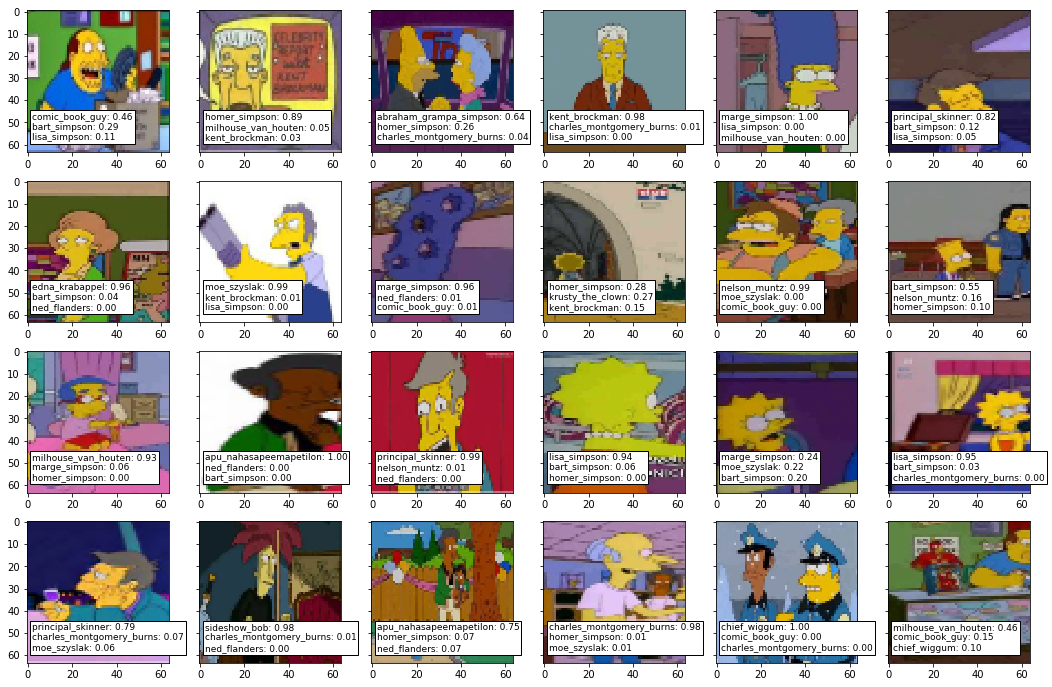

In [0]:
x_test = load_from_paths(x_test_paths)
y_pred = model.predict(x_test)

visualize_results(x_test, y_pred)
y_pred = np.argmax(y_pred, 1)

"Точность на тестовой выборки: {}".format((y_test == y_pred).mean())

In [0]:
print(sklearn.metrics.classification_report(y_test,
    y_pred, target_names=list(map_characters.values())), sep='')

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.92      0.75      0.83        48
  apu_nahasapeemapetilon       1.00      1.00      1.00        50
            bart_simpson       0.84      0.72      0.77        50
charles_montgomery_burns       0.78      0.81      0.80        48
            chief_wiggum       0.94      0.92      0.93        50
          comic_book_guy       0.98      0.88      0.92        49
          edna_krabappel       1.00      0.84      0.91        50
           homer_simpson       0.62      0.88      0.73        50
           kent_brockman       0.96      0.90      0.93        50
        krusty_the_clown       0.96      1.00      0.98        50
            lisa_simpson       0.74      0.74      0.74        50
           marge_simpson       0.90      0.94      0.92        50
     milhouse_van_houten       0.90      0.94      0.92        49
             moe_szyslak       0.84      0.98      0.91        50
         

В разы качество улучшилось, хотя и остаются сильные промахи. Самое приятное - мы теперь **намного уверенее в правильных ответах**, в отличие от предыдущих результатов ну само качество возрасло с **0.52** до **0.88**. Круто!